problem to solve:
a) store houses data from different pages ---> understand where we'll store tha pages
d) jaccard similarity
e) draw wordcloud
f) comments

In [194]:
import os
from bs4 import BeautifulSoup
import pandas as pd
import requests
from requests import get
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from math import log
from math import sqrt
import re
from collections import Counter
from time import sleep
from random import randint
from warnings import warn
import numpy as np
from IPython.core.display import clear_output
from time import time
import sklearn
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.metrics import jaccard_similarity_score
import matplotlib.pyplot as plt
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import pickle

In [150]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Giumas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [151]:
pages = [str(i) for i in range(1,750)]

In [152]:
# Lists to store the scraped data int
prices = []
locals_ = []
surfaces = []
bathrooms = []
floors = []
descriptions = []

In [197]:
with open(r'C:\Users\Giumas\Desktop\HW4Aris\desc', 'rb') as f:
    descriptions = pickle.load(f)

with open(r'C:\Users\Giumas\Desktop\HW4Aris\plan', 'rb') as f:
    floors = pickle.load(f)

with open(r'C:\Users\Giumas\Desktop\HW4Aris\n_bathroom', 'rb') as f:
    bathrooms = pickle.load(f)
    
with open(r'C:\Users\Giumas\Desktop\HW4Aris\mq', 'rb') as f:
    surfaces = pickle.load(f)

with open(r'C:\Users\Giumas\Desktop\HW4Aris\n_room', 'rb') as f:
    locals_ = pickle.load(f)

with open(r'C:\Users\Giumas\Desktop\HW4Aris\price', 'rb') as f:
    prices = pickle.load(f) 
    

In [153]:
# Preparing the monitoring of the loop
start_time = time()
requests = 0

for page in pages:
    url = ('https://www.immobiliare.it/vendita-case/roma/?criterio=rilevanza&pag=' +page)
    response = get(url)
    # Pause the loop
    sleep(randint(8,15))
    # Monitor the requests
    requests += 1
    elapsed_time = time() - start_time
    print('Request:{}; Frequency: {} requests/s'.format(requests, requests/elapsed_time))
    clear_output(wait = True)
    # Throw a warning for non-200 status codes
    if response.status_code != 200:
        warn('Request: {}; Status code: {}'.format(requests, response.status_code))
    # Break the loop if the number of requests is greater than expected
    if requests > 10000:
        warn('Number of requests was greater than expected.')  
        break
    # Parse the content of the request with BeautifulSoup
    page_html = BeautifulSoup(response.text, 'html.parser')
    try :
    # Select all the houses contained from a single page
        house_containers = page_html.find_all('div', class_ = 'listing-item_body--content')
        for house in house_containers:
            house.find('li', class_ = '"lif__item lif__pricing')
            locals_surface_bathrooms = house.findAll('span', class_="text-bold")
            filtering_floor= house.findAll('abbr', class_="text-bold im-abbr") 
    # If the house has all info that need us (price, locals, surface, bathroom and floor) then extract:
        if len(locals_surface_bathrooms) == 3 :
            if len(filtering_floor) >= 1: 
                floor = house.find('abbr', class_="text-bold im-abbr").text.strip()
                if  floor != 'A' and floor != 'S' and floor != 'T':  #don't take houses with A,S,T value for the floor

        # The price
                          price = house.find('li', class_="lif__item lif__pricing").text.strip()
                          #if condition needs us to know if price has got also old price (in this case price has % character)
                          if '%' in price : 
                              price = house.find('div').text.strip()
                          price = re.sub('[€] ', '', price)
                          price = re.sub('[.]', '', price)
                          price = int(price)
                          prices.append(price)

        #the number of locals, surface (m^2), and number of bathrooms
                          local_ = locals_surface_bathrooms[0].text.strip()
                          if '+' in local_:
                              local_ = re.sub('[+]', '', local_)
                          locals_.append(int(local_))
                          surface = locals_surface_bathrooms[1].text.strip()
                          surfaces.append(int(surface))
                          bathroom = locals_surface_bathrooms[2].text.strip()
                          if '+' in bathroom:
                              bathroom = re.sub('[+]', '', bathroom)
                          bathrooms.append(int(bathroom))
        
        #the floor
                          floors.append(int(floor))

        # the description
                          description = house.find('p', class_="descrizione__truncate").text.strip()
                          descriptions.append(description)
    except :
        pass

Request:749; Frequency: 0.07559714603060451 requests/s


In [199]:
prices2 = prices[:10000]
locals2 = locals_[:10000]
surfaces2 = surfaces[:10000]
bathrooms2 = bathrooms[:10000]
floors2 = floors[:10000]
descriptions2 = descriptions[:10000]

In [200]:
len(floors2)

10000

In [201]:
info_matrix = pd.DataFrame({'price':prices2,
                           'locals':locals2,
                           'surface':surfaces2,
                           'bathroom':bathrooms2,
                           'floor':floors2})
info_matrix.to_csv("firstMatrix.csv")
info_matrix1 = pd.read_csv("firstMatrix.csv")

In [202]:
info_matrix

,price,locals,surface,bathroom,floor
0,225000,2,50,1,1
1,395000,5,130,2,1
2,3700000,5,250,3,5
3,850000,5,175,2,5
4,279000,3,110,1,1
5,520000,3,105,2,1
6,269000,3,87,2,3
7,1050000,5,235,3,3
8,1800000,5,250,3,3
9,1650000,5,220,3,4


Let's to cleaning houses description

In [203]:
def clening_description(description):  # use all the techniques to remove unwanted items from words
    
    tokenizer = RegexpTokenizer(r'\w+')
    ps = PorterStemmer()
    # Remove "\\n" and replace with a space
    description = description.replace("\\n", " ")
    # Convert everything to lowercase
    description = description.lower()
    # Removing punctuation
    description = tokenizer.tokenize(description)
    # Removing stopwords
    description = [word for word in description if word not in stopwords.words('italian')]
    # No integers
    description = [x for x in description if not (x.isdigit() or x[0].isdigit())]
    return description

In [204]:
cleaned_descriptions = []
for description in descriptions:
    cleaned_description = clening_description(description)
    cleaned_descriptions.append(' '.join(cleaned_description))  

In [205]:
corpus = [y for x in cleaned_descriptions for y in x]

#all words present in all descriptions

In [206]:
count_corpus = Counter(corpus)
count_corpus= dict(count_corpus.most_common())

final_dict = {str(i+1):x for i,x in enumerate(count_corpus)}
final_dict_inv = {str(x):(i+1) for i,x in enumerate(count_corpus)}

In [259]:
final_dict

{'1': ' ',
 '2': 'i',
 '3': 'a',
 '4': 'o',
 '5': 'e',
 '6': 't',
 '7': 'r',
 '8': 'n',
 '9': 's',
 '10': 'c',
 '11': 'm',
 '12': 'l',
 '13': 'p',
 '14': 'u',
 '15': 'd',
 '16': 'z',
 '17': 'g',
 '18': 'v',
 '19': 'b',
 '20': 'f',
 '21': 'q',
 '22': 'h',
 '23': 'à',
 '24': 'w',
 '25': 'x',
 '26': 'k',
 '27': 'y',
 '28': 'ì',
 '29': 'é',
 '30': '2',
 '31': '1',
 '32': '0',
 '33': 'ò',
 '34': 'j',
 '35': '3',
 '36': '4',
 '37': 'è',
 '38': '6',
 '39': '9',
 '40': '5',
 '41': '7',
 '42': '8',
 '43': '_',
 '44': 'ü',
 '45': '²',
 '46': 'ù',
 '47': 'ö',
 '48': 'ä',
 '49': 'á',
 '50': 'ó',
 '51': 'ñ',
 '52': 'ß',
 '53': 'â',
 '54': 'í',
 '55': 'ê',
 '56': 'å',
 '57': 'ú',
 '58': 'ô',
 '59': 'ç',
 '60': 'î',
 '61': 'æ',
 '62': 'ƒ',
 '63': 'œ',
 '64': 'ë'}

In [207]:
indx = {}
for n,document in enumerate(cleaned_descriptions):
    new_document = []
    for word in document:
        new_document.append(final_dict_inv[str(word)])
    indx[str(n+1)] = new_document 
    
inv_indx = {str(i):[] for i in list(final_dict.keys())}
for word in list(final_dict.keys()):
    for i in range(len(indx)):
        if int(word) in indx[str(i+1)]:
            inv_indx[word].append(i+1)

In [208]:
houses_count= len(info_matrix)

In [209]:
inv_indx2 = {i:[] for i in list(final_dict.keys())}
for word in list(final_dict.keys()):
    for i,l in enumerate(list(indx.values())):
        if int(word) in l:
            tf = l.count(int(word))/len(l)
            id_f = log(houses_count/len(inv_indx[word]))
            inv_indx2[word].append((i+1,tf*id_f))

In [260]:
tf

0.0017605633802816902

In [261]:
id_f

9.210340371976184

In [210]:
converting = [(k, *t) for k, v in inv_indx2.items() for t in v ]


In [211]:
test = pd.DataFrame(converting, columns=['Word', 'Document', 'Tf-Idf'])

In [212]:
matrix_tfidf = test.pivot_table(index = 'Document', columns = 'Word', values='Tf-Idf', fill_value = 0)[:10000]

In [213]:
matrix_tfidf.head()

Word,1,10,11,12,13,14,15,16,17,18,...,59,6,60,61,62,63,64,7,8,9
Document,,,,,,,,,,,,,,,,,,,,,
1,-0.010574,-0.003574,-0.002532,-0.004761,-0.002085,-0.001782,-0.001736,-0.000990,-0.001598,-0.000983,...,0.0,-0.007745,0.0,0.0,0.0,0.0,0.0,-0.006106,-0.005957,-0.003723
2,-0.010906,-0.002936,-0.005033,-0.002724,-0.005033,-0.001673,-0.001019,-0.001195,-0.000614,-0.001186,...,0.0,-0.007969,0.0,0.0,0.0,0.0,0.0,-0.004614,-0.007131,-0.002517
3,-0.011499,-0.003999,-0.003142,-0.004138,-0.002785,-0.002065,-0.001665,-0.001085,-0.001045,-0.001347,...,0.0,-0.007499,0.0,0.0,0.0,0.0,0.0,-0.005999,-0.004214,-0.003642
4,-0.011327,-0.003079,-0.003629,-0.003626,-0.004289,-0.001425,-0.002564,-0.001462,-0.001073,-0.001140,...,0.0,-0.007258,0.0,0.0,0.0,0.0,0.0,-0.004399,-0.005829,-0.002749
5,-0.011546,-0.004422,-0.002702,-0.003068,-0.003439,-0.001959,-0.000835,-0.000467,-0.001438,-0.001505,...,0.0,-0.007615,0.0,0.0,0.0,0.0,0.0,-0.005159,-0.005650,-0.003930


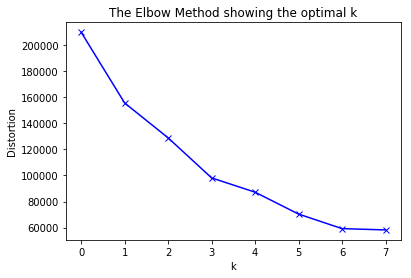

In [214]:
# k means determine k for first matrix 
distortions = []
for k in range(2,10):
    kmeanModel = KMeans(n_clusters=k, init='k-means++').fit(info_matrix)
    kmeanModel.fit(info_matrix)
    distortions.append(sum(np.min(cdist(info_matrix, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / info_matrix.shape[0])

# Plot the elbow
plt.plot( distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

The elbow matrix shows that the better number of cluster for the first matrix is 5 (the point where the plot starts the "elbow")

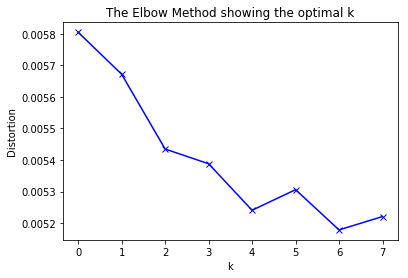

In [215]:
# k means determine k for second matrix
distortions = []
for k in range(2,10):
    kmeanModel = KMeans(n_clusters=k, init='k-means++').fit(matrix_tfidf)
    kmeanModel.fit(matrix_tfidf)
    distortions.append(sum(np.min(cdist(matrix_tfidf, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / matrix_tfidf.shape[0])

# Plot the elbow
plt.plot( distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

The elbow matrix shows that there'is a visible better number of cluster for the second matrix. So we choise to deal with 10 clusters

In [216]:
# kmeans++ clustering for first matrix with k = 3 (choosen with elbow method)
cluster = sklearn.cluster.KMeans(n_clusters=3, init='k-means++').fit(info_matrix)
labels = cluster.labels_

In [217]:
# kmeans++ clustering for second matrix with k = 3 (choose with elbow method) dal tre inizia a scendere
cluster2 = sklearn.cluster.KMeans(n_clusters=4, init='k-means++').fit(matrix_tfidf)
labels2 = cluster2.labels_

Let's add label column to both matrixs to know the number of cluster for each announcement and for each document

In [218]:
labels_se = pd.Series(labels)
info_matrix['labels'] = labels_se.values
info_matrix.head()

,price,locals,surface,bathroom,floor,labels
0,225000,2,50,1,1,0
1,395000,5,130,2,1,0
2,3700000,5,250,3,5,1
3,850000,5,175,2,5,2
4,279000,3,110,1,1,0


In [219]:
labels2_se = pd.Series(labels2)
matrix_tfidf['labels2'] = labels2_se.values
matrix_tfidf.head()

Word,1,10,11,12,13,14,15,16,17,18,...,6,60,61,62,63,64,7,8,9,labels2
Document,,,,,,,,,,,,,,,,,,,,,
1,-0.010574,-0.003574,-0.002532,-0.004761,-0.002085,-0.001782,-0.001736,-0.000990,-0.001598,-0.000983,...,-0.007745,0.0,0.0,0.0,0.0,0.0,-0.006106,-0.005957,-0.003723,0
2,-0.010906,-0.002936,-0.005033,-0.002724,-0.005033,-0.001673,-0.001019,-0.001195,-0.000614,-0.001186,...,-0.007969,0.0,0.0,0.0,0.0,0.0,-0.004614,-0.007131,-0.002517,0
3,-0.011499,-0.003999,-0.003142,-0.004138,-0.002785,-0.002065,-0.001665,-0.001085,-0.001045,-0.001347,...,-0.007499,0.0,0.0,0.0,0.0,0.0,-0.005999,-0.004214,-0.003642,0
4,-0.011327,-0.003079,-0.003629,-0.003626,-0.004289,-0.001425,-0.002564,-0.001462,-0.001073,-0.001140,...,-0.007258,0.0,0.0,0.0,0.0,0.0,-0.004399,-0.005829,-0.002749,0
5,-0.011546,-0.004422,-0.002702,-0.003068,-0.003439,-0.001959,-0.000835,-0.000467,-0.001438,-0.001505,...,-0.007615,0.0,0.0,0.0,0.0,0.0,-0.005159,-0.005650,-0.003930,1


Ora bisogna calcolare il jaccard similarity tra coppie di cluster. La colonna label e labels2 servono a specificare, per ogni riga,
a quale cluster appartiene (per la prima matrice da 0 a 4 (i cluster sono 5), seconda i cluster vanno da 0 a 19 (i cluster sono 20)).
La jaccard va calcolata tra coppie di cluster appartenenti alle due matrici: quindi tra cluster 0 della matrice 1 e cluster 0 della matrice 2, ecc ecc.

In [220]:
sims = {}
for i,label in enumerate(info_matrix['labels']):
    if label not in sims:
        sims[label] = [i+1]
    if label in sims:
        sims[label].append(i+1)
sims2 = {}
for i,label in enumerate(matrix_tfidf['labels2']):
    if label not in sims2:
        sims2[label] = [i+1]
    if label in sims2:
        sims2[label].append(i+1)

In [221]:
keypair= {}
for clust in sims:
    for clust2 in sims2:
        keypair[str(clust),str(clust2)]= len(set.intersection(set(sims[clust]),set(sims2[clust2])))/len(set.union(set(sims[clust]),set(sims2[clust2])))

In [222]:
highest3 = sorted(keypair.values(), reverse = True)[:3]

In [223]:
clust3 = []
for key in keypair:
    if keypair[key] in highest3:
        clust3.append(key)

In [224]:
cloud=[]

for tuple_ in clust3:
    announcements = []
    for i,clust in enumerate(info_matrix['labels']):
        if int(tuple_[0]) == clust:
            announcements.append(i+1)
    for i,clust in enumerate(matrix_tfidf['labels2']):
        if int(tuple_[1]) == clust:
            announcements.append(i+1)
    cloud.append(announcements)


In [225]:
couple_desc = []
for couple in cloud:
    descs = []
    for idx in couple:
        descs.append(cleaned_descriptions[idx])
    couple_desc.append(''.join(descs))

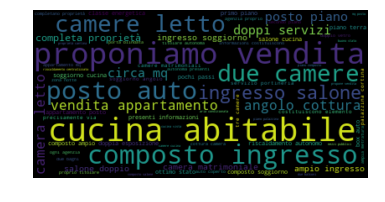

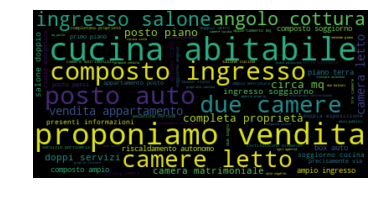

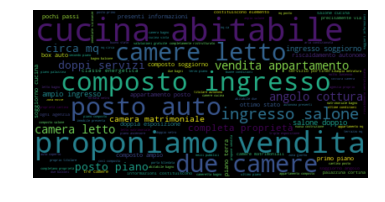

In [257]:
# Create and generate a word cloud image:
for desc in range(len(couple_desc)):
    wordcloud = WordCloud().generate(couple_desc[desc])

# Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [250]:
text=" ".join(i for i in couple_desc)


In [255]:
# Create and generate a word cloud image:
cloudd = np.array(Image.open(r'C:\Users\Giumas\Desktop\logo.png'))
cloudd[cloudd == 0 ] = 255
wc = WordCloud(background_color="white", max_words=2000, mask=cloudd, contour_width=1, contour_color='white')



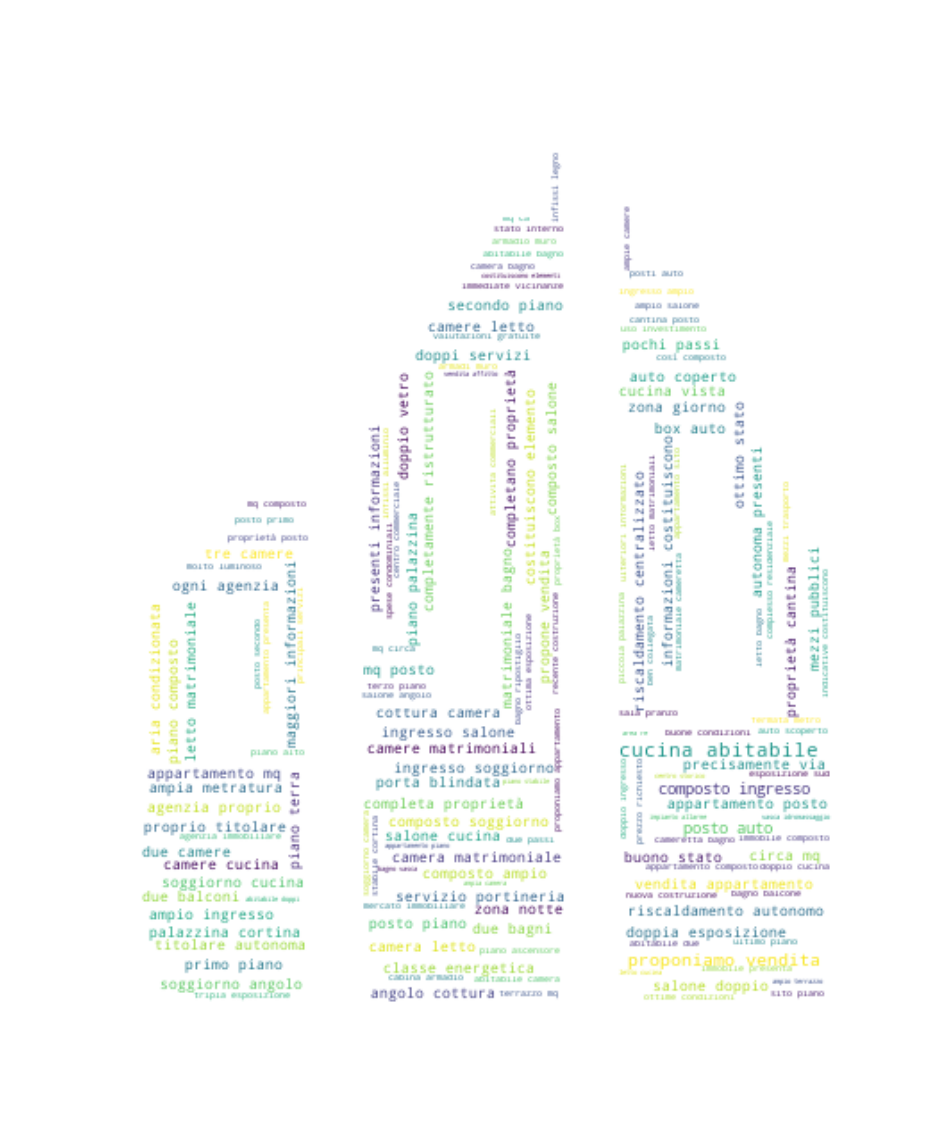

In [258]:
wc.generate(text)
# Display the generated image:
plt.figure(figsize=[40,20])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()